# Optical Flow
This notebook presents how to use DALI to calculate optical flow for a given sequence of frames.

Let's start with some handy imports

In [1]:
import os
from pathlib import Path

import numpy as np

import nvidia.dali.experimental.dynamic as ndd

from matplotlib import pyplot as plt

Setting metaparameters.  
As an example we use [Sintel trailer](https://durian.blender.org/), included in [DALI_extra](https://github.com/NVIDIA/DALI_extra) repository. Feel free to verify against your own video data.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [2]:
sequence_length = 10
dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
video_filename = str(
    dali_extra_dir
    / "db"
    / "optical_flow"
    / "sintel_trailer"
    / "sintel_trailer_short.mp4"
)

Functions used for Optical flow visualization.  
The code comes from [Tomrunia's GitHub](https://github.com/tomrunia/OpticalFlow_Visualization "OpticalFlow_Visualization")

In [3]:
def make_colorwheel():
    """
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow"
        (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    """

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255 * np.arange(0, RY) / RY)
    col = col + RY
    # YG
    colorwheel[col : col + YG, 0] = 255 - np.floor(255 * np.arange(0, YG) / YG)
    colorwheel[col : col + YG, 1] = 255
    col = col + YG
    # GC
    colorwheel[col : col + GC, 1] = 255
    colorwheel[col : col + GC, 2] = np.floor(255 * np.arange(0, GC) / GC)
    col = col + GC
    # CB
    colorwheel[col : col + CB, 1] = 255 - np.floor(255 * np.arange(CB) / CB)
    colorwheel[col : col + CB, 2] = 255
    col = col + CB
    # BM
    colorwheel[col : col + BM, 2] = 255
    colorwheel[col : col + BM, 0] = np.floor(255 * np.arange(0, BM) / BM)
    col = col + BM
    # MR
    colorwheel[col : col + MR, 2] = 255 - np.floor(255 * np.arange(MR) / MR)
    colorwheel[col : col + MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    """
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR
                                 instead of RGB
    :return:
    """

    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u) / np.pi

    fk = (a + 1) / 2 * (ncols - 1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0

    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:, i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1 - f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        col[~idx] = col[~idx] * 0.75  # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2 - i if convert_to_bgr else i
        flow_image[:, :, ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    """
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    """

    assert flow_uv.ndim == 3, "input flow must have three dimensions"
    assert flow_uv.shape[2] == 2, "input flow must have shape [H,W,2]"

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:, :, 0]
    v = flow_uv[:, :, 1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)

## Using DALI

We create a video reader and call [optical_flow](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.optical_flow.html) on the video tensor to compute the optical flow.

For more information, please refer to [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) and [optical_flow](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.optical_flow.html) documentation.

In [4]:
reader = ndd.readers.Video(
    device="gpu",
    filenames=video_filename,
    sequence_length=sequence_length,
    file_list_include_preceding_frame=True,
)

video = reader()
of = ndd.optical_flow(video, output_grid=4)
of = of.cpu()
print(of.shape)

(9, 180, 320, 2)


Above you can see the shape of the calculated optical flow (in FHWC format). It contains 2 channels: flow vector in `x` axis and flow vector in `y` axis. Output resolution is determined by `output_grid` option passed to `optical_flow` operator: for `output_grid = 4`, 4x4 grid is used for flow calculation, thus resolution in every dimension being 4 times smaller than the resolution of the input image.

### Visualize Results

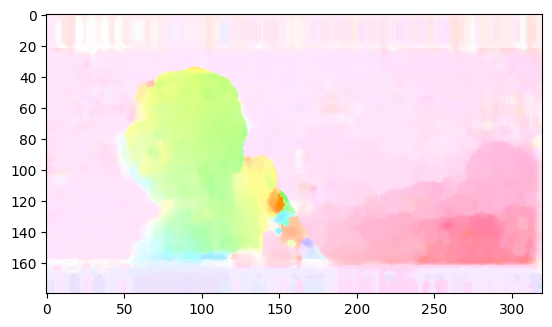

In [5]:
of_result = flow_to_color(of[sequence_length // 2])
plt.imshow(of_result)